# This is an introductory tutorial for the Harmonic Oscilator with Openmm

## The objectives are:
1. Set up a system consisting of harmonic oscilator
2. Change the initial position of the particle and calculate the potential energy and force
3. Minimize the potential energy
4. Perform molecular dynamics simulations at different timesteps to monitor integration errors

## Homework:

1. Create two alternative harmonic oscilators with doubled mass (or doubled force constants) 
2. Repeat point 2 and 3 with the two harmonic oscillators: How does the potential energy and force change
3. Choose the appropiate time step for the new harmonic oscilator
4. Integrate equation of motion with verlocity verlet


In [1]:
from simtk import openmm, unit
from simtk.openmm import app
import numpy as np
from openmmtools import testsystems

In [2]:
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.stats import linregress
%matplotlib inline

In [3]:
Ho_1 = testsystems.HarmonicOscillator()

In [4]:
help(Ho_1)

Help on HarmonicOscillator in module openmmtools.testsystems object:

class HarmonicOscillator(TestSystem)
 |  Create a 3D harmonic oscillator, with a single particle confined in an isotropic harmonic well.
 |  
 |  Parameters
 |  ----------
 |  K : simtk.unit.Quantity, optional, default=100.0 * unit.kilocalories_per_mole/unit.angstrom**2
 |      harmonic restraining potential
 |  mass : simtk.unit.Quantity, optional, default=39.948 * unit.amu
 |      particle mass
 |  U0 : simtk.unit.Quantity, optional, default=0.0 * unit.kilocalories_per_mole
 |      Potential offset for harmonic oscillator
 |  
 |  The functional form is given by
 |  
 |  U(x) = (K/2) * ( (x-x0)^2 + y^2 + z^2 ) + U0
 |  
 |  Attributes
 |  ----------
 |  system : simtk.openmm.System
 |      Openmm system with the harmonic oscillator
 |  positions : list
 |      positions of harmonic oscillator
 |  
 |  Context parameters
 |  ------------------
 |  testsystems_HarmonicOscillator_K
 |      Spring constant of harmonic 

In [5]:
position = Ho_1.positions

In [6]:
print(position)

[[0. 0. 0.]] A


### Now we change the position (point 2)

In [7]:
new_position = [[1 , 0, 0]]
Ho_1.positions = new_position
print(Ho_1.positions)

[[1, 0, 0]]


It is better to use the unit in the position. Standard unit in the harmonic oscilator are kcal/mol and kcal/mol/AA^2

In [8]:
new_position = [[1 * unit.angstrom , 0, 0]]
Ho_1.positions = new_position
print(Ho_1.positions)

[[Quantity(value=1, unit=angstrom), 0, 0]]


Now we define an integrator class with the verlet intergrator and a timestep o 1 fs.


In [9]:
timestep = 1.0 * unit.femtosecond
integrator = openmm.VerletIntegrator(timestep)

With the integrator we define a context class which stores the current state of the simulation.

In [10]:
context = openmm.Context(Ho_1.system,integrator)

Before doing anything with context class we have to define the initial position

In [11]:
context.setPositions(Ho_1.positions)

With this initial position we want to know some properties of the harmonic oscilator in the current state as:

1. Potential energy
2. Force

This is done with the getState function of context class and the output is a copy of the current state which contains  all variables which were set to True. This variables can be obtained with the getXXX function of the new class

In [13]:
context.getState?

In [14]:
state = context.getState(getEnergy=True, getForces=True)
potential_energy = state.getPotentialEnergy()

In [15]:
print(potential_energy)

209.20001220703125 kJ/mol


Question: Is this value correct? 

In [16]:
print(state.getForces())

[Vec3(x=-4184.0, y=0.0, z=0.0)] kJ/(nm mol)


Let´s reduce the position in x to only 0.1 angstrom

In [17]:
position = [[0.1 * unit.angstrom, 0., 0.]]

In [18]:
context.setPositions(position)

In [19]:
state = context.getState(getEnergy=True, getForces=True)

In [20]:
print(state.getPotentialEnergy(), state.getForces())

2.0920000076293945 kJ/mol [Vec3(x=-418.3999938964844, y=0.0, z=0.0)] kJ/(nm mol)


Question: Why is the energy 100 times smaller when we divided the position by 10?

### Now let´s minimize the potential energy of the harmonic oscilator system with the LocalEnergyMinimizer class (point 3)

In [21]:
openmm.LocalEnergyMinimizer.minimize(context)

In [22]:
state = context.getState(getPositions=True,getEnergy=True)

In [23]:
state.getPositions(), state.getPotentialEnergy()

(Quantity(value=[Vec3(x=-7.763989451348152e-11, y=0.0, z=0.0)], unit=nanometer),
 Quantity(value=1.2610478287956254e-16, unit=kilojoule/mole))

We are at the bottom of the harmonic oscilator again. 

### Let´s go back to the original positions and do some molecular dynamics at constant energy (microcanonical ensemble) (point 4)

The total simulation time will be 3 times the period of the oscilator which is given as:

In [24]:
T = 2 * np.pi * np.sqrt(Ho_1.mass / Ho_1.K)
print(T)

0.19414738754194238 ps


First start a new simulation with a new context class using a timestep the factor times smaller than the period

In [61]:
del context, integrator
factor = 10
timestep = T / factor
integrator = openmm.VerletIntegrator(timestep)
position = [[0.1 * unit.nanometer, 0., 0.]]
context = openmm.Context(Ho_1.system,integrator)
context.setPositions(position)

In [62]:
total_iterations = factor 
for iteration in range(total_iterations + 1):
    state = context.getState(getEnergy=True,getPositions=True)   
    print('%8.3f ps : position %12.6f nm' % (state.getTime() / unit.picoseconds, state.getPositions()[0][0] / unit.nanometer))
    integrator.step(1)

   0.000 ps : position     0.100000 nm
   0.019 ps : position     0.060522 nm
   0.039 ps : position    -0.002850 nm
   0.058 ps : position    -0.065096 nm
   0.078 ps : position    -0.101644 nm
   0.097 ps : position    -0.098064 nm
   0.116 ps : position    -0.055770 nm
   0.136 ps : position     0.008541 nm
   0.155 ps : position     0.069480 nm
   0.175 ps : position     0.102989 nm
   0.194 ps : position     0.095840 nm


Questions: 

1.) Why is the final position not exactly the one at the beginning after one period?

2.) What can you do to make them equal each other?

Let´s look at the potential enerygy after one periods of oscilation

In [48]:
del context, integrator
factor = 10
timestep = T / factor
integrator = openmm.VerletIntegrator(timestep)
position = [[0.1 * unit.nanometer, 0., 0.]]
context = openmm.Context(Ho_1.system,integrator)
context.setPositions(position)

In [49]:
total_iterations = factor  + 1
for iteration in range(total_iterations):
    state = context.getState(getEnergy=True, getPositions=True)   
    print('%8.3f ps : energy %12.6f kJ/mol' % (state.getTime() / unit.picoseconds, state.getPotentialEnergy() / unit.kilojoule_per_mole))
    integrator.step(1)


   0.000 ps : energy   209.200012 kJ/mol
   0.019 ps : energy    76.627052 kJ/mol
   0.039 ps : energy     0.169900 kJ/mol
   0.058 ps : energy    88.648636 kJ/mol
   0.078 ps : energy   216.133057 kJ/mol
   0.097 ps : energy   201.176819 kJ/mol
   0.116 ps : energy    65.066917 kJ/mol
   0.136 ps : energy     1.526111 kJ/mol
   0.155 ps : energy   100.990929 kJ/mol
   0.175 ps : energy   221.894882 kJ/mol
   0.194 ps : energy   192.157486 kJ/mol


Let´s look at the force after one period of oscilation

In [50]:
del context, integrator
factor = 10
timestep = T / factor
integrator = openmm.VerletIntegrator(timestep)
position = [[0.1 * unit.nanometer, 0., 0.]]
context = openmm.Context(Ho_1.system,integrator)
context.setPositions(position)

In [52]:
total_iterations = factor
for iteration in range(total_iterations + 1):
    state = context.getState(getEnergy=True,getForces=True)   
    print('%8.3f ps : position %12.6f kJ/mol/nm' % (state.getTime() / unit.picoseconds, state.getForces()[0][0] / unit.kilojoule_per_mole *unit.nanometer))
    integrator.step(1)

   0.194 ps : position -4009.954834 kJ/mol/nm
   0.214 ps : position -2127.763916 kJ/mol/nm
   0.233 ps : position   594.434692 kJ/mol/nm
   0.252 ps : position  3081.959717 kJ/mol/nm
   0.272 ps : position  4352.775879 kJ/mol/nm
   0.291 ps : position  3905.184570 kJ/mol/nm
   0.311 ps : position  1915.888062 kJ/mol/nm
   0.330 ps : position  -829.770447 kJ/mol/nm
   0.349 ps : position -3247.848633 kJ/mol/nm
   0.369 ps : position -4383.727539 kJ/mol/nm
   0.388 ps : position -3788.979980 kJ/mol/nm


Store the position, forces and energy in arrays to analyze them

In [53]:
del context, integrator
factor = 10
timestep = T / factor
integrator = openmm.VerletIntegrator(timestep)
position = [[0.1 * unit.nanometer, 0., 0.]]
context = openmm.Context(Ho_1.system,integrator)
context.setPositions(position)

In [54]:
time = []
positions = []
energy = []
forces = []
total_iterations = factor
for iteration in range(total_iterations):
    state = context.getState(getEnergy=True,getPositions=True, getForces=True)
    time.append(state.getTime() / unit.picoseconds)
    position = (state.getPositions(asNumpy=True) / unit.nanometer)
    positions.append(position[0][0])
    force = (state.getForces(asNumpy=True) / unit.kilojoule_per_mole * unit.nanometer)
    forces.append(force[0][0])
    energy.append(state.getPotentialEnergy() / unit.kilojoule_per_mole)
    integrator.step(1)

Let´s plot the position as function of time

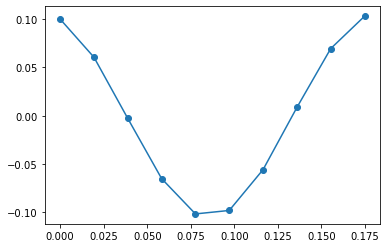

In [55]:
plt.plot(time,positions,'-o')

Now let´s plot the potential energy

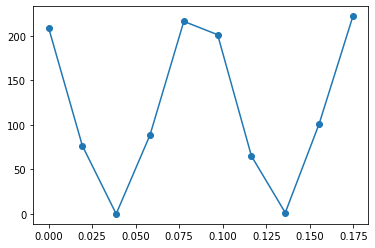

In [56]:
plt.plot(time,energy,'-o')

Plot the force as fucntion of time

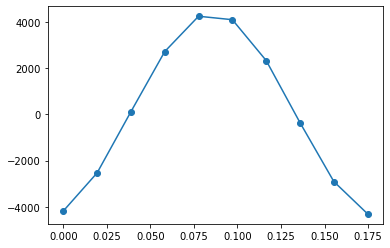

In [57]:
plt.plot(time,forces,'o-')

After one period the forces should be zero if the integration is done correctly.

In [58]:
sum(forces), forces[0]

(-757.6898651123047, -4184.0)

Task:

Go back and change the value of factor until the sum is close to zero.

Why can´t you reach zero?